#Installing and Importing libraries

Need mount your Google Drive folder, make sure you change the directory to the one where you paste the entire repository

In [1]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/mydir')

# Define the path for the folder where you want to clone the repository
folder_path = '/content/mydir/MyDrive/Quantum-Dynamics-Tutorial/GQME_Tutorial'

# Create the folder if it doesn't already exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Created folder: {folder_path}")

# Change the current working directory to the folder where you want to clone the repository
os.chdir(folder_path)

# Clone the GitHub Repository into the specified folder
!git clone https://github.com/XiaohanDan97/CCI_PartIII_GQME ./

Mounted at /content/mydir
Created folder: /content/mydir/MyDrive/Quantum-Dynamics-Tutorial/GQME_Tutorial
Cloning into '.'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 114 (delta 22), reused 4 (delta 2), pack-reused 61 (from 1)
Receiving objects: 100% (114/114), 3.54 MiB | 7.54 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [2]:
import numpy as np
np.float = float
np.complex = complex
import time

#parameters in the simulation
from params import *
#read and write functions
import readwrite as wr

import matplotlib.pyplot as plt

SPIN-BOSON Model parameter
        epsilon = 1
             xi = 0.1
        omega_c = 2
      omega_max = 10
     time steps = 2000
             DT = 0.0015008299950527925
     final time = 3.001659990105585
          DOF_E = 2
          DOF_N = 60


#Using TT-TFD to simulate Spin-Boson Model Dynamics

The tensor-train library, ttpy, is available at https://github.com/bcallen95/ttpy.git (forked from https://github.com/oseledets/ttpy) and must be on your computer before doing the TT-TFD.

In [26]:
#The two block below calculates dynamics with TT-TFD. The expected waiting time is 10 minutes on Google Colab.
#To save time, the results are already pre-computed and saved.
#The following code would still run normally without running TT-TFD.
#To run the dynamics through TT-TFD, change Is_run_dynamics = True

Is_run_dynamics = False
if Is_run_dynamics:
  !pip install git+https://github.com/bcallen95/ttpy.git --quiet

In [4]:
if Is_run_dynamics:
  import tt_tfd as tfd

  #RDO: reduced density operator, contain the information of population and coherence
  #initial_state=0: initial at Donor state
  t, RDO_arr = tfd.tt_tfd(initial_state=0)

  #TT-TFD is time consuming, after running it once, you can read it from the file without running it again
  #output to the file
  wr.output_operator_array(t, RDO_arr, "TTTFD_Output/TFDSigma_")

This is a 121-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=1, n(1)=10 
r(2)=1, n(2)=10 
r(3)=1, n(3)=10 
r(4)=1, n(4)=10 
r(5)=1, n(5)=10 
r(6)=1, n(6)=10 
r(7)=1, n(7)=10 
r(8)=1, n(8)=10 
r(9)=1, n(9)=10 
r(10)=1, n(10)=10 
r(11)=1, n(11)=10 
r(12)=1, n(12)=10 
r(13)=1, n(13)=10 
r(14)=1, n(14)=10 
r(15)=1, n(15)=10 
r(16)=1, n(16)=10 
r(17)=1, n(17)=10 
r(18)=1, n(18)=10 
r(19)=1, n(19)=10 
r(20)=1, n(20)=10 
r(21)=1, n(21)=10 
r(22)=1, n(22)=10 
r(23)=1, n(23)=10 
r(24)=1, n(24)=10 
r(25)=1, n(25)=10 
r(26)=1, n(26)=10 
r(27)=1, n(27)=10 
r(28)=1, n(28)=10 
r(29)=1, n(29)=10 
r(30)=1, n(30)=10 
r(31)=1, n(31)=10 
r(32)=1, n(32)=10 
r(33)=1, n(33)=10 
r(34)=1, n(34)=10 
r(35)=1, n(35)=10 
r(36)=1, n(36)=10 
r(37)=1, n(37)=10 
r(38)=1, n(38)=10 
r(39)=1, n(39)=10 
r(40)=1, n(40)=10 
r(41)=1, n(41)=10 
r(42)=1, n(42)=10 
r(43)=1, n(43)=10 
r(44)=1, n(44)=10 
r(45)=1, n(45)=10 
r(46)=1, n(46)=10 
r(47)=1, n(47)=10 
r(48)=1, n(48)=10 
r(49)=1, n(49)=10 
r(50)=1, n(50)=10 
r(51)=1, n(51)=10 

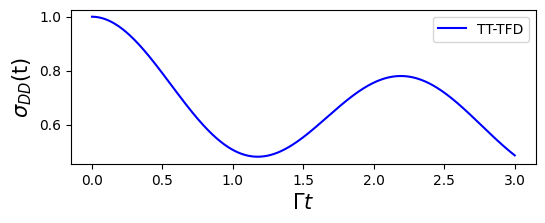

In [5]:
#read and plot
t, RDO_arr = wr.read_operator_array("TTTFD_Output/TFDSigma_")
plt.figure(figsize=(6,2))
plt.plot(t, RDO_arr[:,0].real,'b-', label='TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend()

#Using GQME to simulate Spin-Boson Model dynamics

##The projected Liouvillian

In [6]:
LN0 = np.zeros((DOF_E_SQ, DOF_E_SQ))
LN0[0][1] = LN0[1][0] = LN0[2][3] = LN0[3][2] = -GAMMA_DA
LN0[0][2] = LN0[2][0] = LN0[1][3] = LN0[3][1] = GAMMA_DA
LN0[1][1] = 2. * EPSILON
LN0[2][2] = -2. * EPSILON

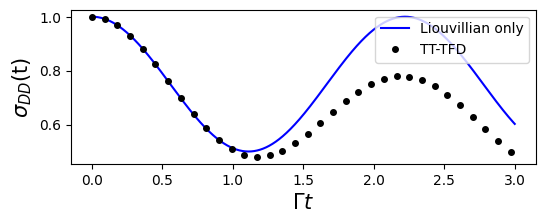

In [7]:
from scipy.linalg import expm
sigma_liou = np.zeros((TIME_STEPS, DOF_E_SQ), dtype=np.complex_)
time_arr = np.linspace(0,(TIME_STEPS-1)*DT,TIME_STEPS)
sigma_liou[0] = np.array([1.0,0,0,0],dtype=np.complex_)
for i in range(1,TIME_STEPS):
  sigma_liou[i] = expm(-1j*LN0*i*DT)@sigma_liou[0]

#read TT-TFD result and plot to compare
timeVec, sigma_tt_tfd = wr.read_operator_array("TTTFD_Output/TFDSigma_")
plt.figure(figsize=(6,2))
plt.plot(time_arr, sigma_liou[:,0].real,'b-', label='Liouvillian only')
plt.plot(timeVec,  sigma_tt_tfd[:,0].real,'ko', markersize=4,markevery=60, label='TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = 'upper right')

## Calculating the Memory Kernel

### The Projection-Free Inputs

In [8]:
def cal_U_tt_tfd():

    U = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)

    # tt-tfd with initial state 0,1,2,3
    # initial state |0> means donor state |D>, |3> means acceptor state |A>
    # |1> is (|D> + |A>)/sqrt(2), |2> is (|D> + i|A>)/sqrt(2)
    t,U[:,:,0] = tfd.tt_tfd(0)
    t,U[:,:,1] = tfd.tt_tfd(1)
    t,U[:,:,2] = tfd.tt_tfd(2)
    t,U[:,:,3] = tfd.tt_tfd(3)

    U_final = U.copy()

    # the coherence elements that start at initial state |D><A| and |A><D|
    # is the linear combination of above U results
    # |D><A| = |1><1| + i * |2><2| - 1/2 * (1 + i) * (|0><0| + |3><3|)
    U_final[:,:,1] = U[:,:,1] + 1.j * U[:,:,2] - 0.5 * (1. + 1.j) * (U[:,:,0] + U[:,:,3])

    # |A><D| = |1><1| - i * |2><2| - 1/2 * (1 - i) * (|0><0| + |3><3|)
    U_final[:,:,2] = U[:,:,1] - 1.j * U[:,:,2] - 0.5 * (1. - 1.j) * (U[:,:,0] + U[:,:,3])

    #output U
    wr.output_superoper_array(t,U_final,"U_Output/U_")

    return 0

In [9]:
#The line below calculates all U elements with TT-TFD. The expected waiting time is 40 minutes on Google Colab.
#To save time, the results are already pre-computed and saved, and Is_run_dynamics is therefore set as False.
#The following code would still run normally. Please set Is_run_dynamics = True if one wishes to perform these calculations.
if Is_run_dynamics:
  cal_U_tt_tfd()

Streaming output truncated to the last 5000 lines.
1499 2.249744162584136
1500 2.251244992579189
1501 2.2527458225742416
1502 2.2542466525692944
1503 2.255747482564347
1504 2.2572483125594
1505 2.2587491425544526
1506 2.2602499725495053
1507 2.2617508025445585
1508 2.2632516325396113
1509 2.264752462534664
1510 2.2662532925297167
1511 2.2677541225247695
1512 2.2692549525198222
1513 2.270755782514875
1514 2.2722566125099277
1515 2.2737574425049805
1516 2.2752582725000337
1517 2.2767591024950864
1518 2.278259932490139
1519 2.279760762485192
1520 2.2812615924802446
1521 2.2827624224752974
1522 2.28426325247035
1523 2.285764082465403
1524 2.2872649124604556
1525 2.288765742455509
1526 2.2902665724505615
1527 2.2917674024456143
1528 2.293268232440667
1529 2.2947690624357198
1530 2.2962698924307725
1531 2.2977707224258253
1532 2.299271552420878
1533 2.3007723824159307
1534 2.302273212410984
1535 2.3037740424060367
1536 2.3052748724010894
1537 2.306775702396142
1538 2.308276532391195
1539 2.3

In [10]:
def cal_F():
    #read the propagator data from files
    timeVec,U = wr.read_superoper_array("U_Output/U_")

    F = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)
    Fdot = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)

    for j in range(DOF_E_SQ):
        for k in range(DOF_E_SQ):
            # extracts real and imag parts of U element
            Ureal = U[:,j,k].copy().real
            Uimag = U[:,j,k].copy().imag

            # F = i * d/dt U so Re[F] = -1 * d/dt Im[U] and Im[F] = d/dt Re[U]
            Freal = -1. * np.gradient(Uimag.flatten(), DT, edge_order = 2)
            Fimag = np.gradient(Ureal.flatten(), DT, edge_order = 2)

            # Fdot = d/dt F so Re[Fdot] = d/dt Re[F] and Im[Fdot] = d/dt Im[F]
            Fdotreal = np.gradient(Freal, DT)
            Fdotimag = np.gradient(Fimag, DT)

            F[:,j,k] = Freal[:] + 1.j * Fimag[:]
            Fdot[:,j,k] = Fdotreal[:] + 1.j * Fdotimag[:]

    #write the result to the file
    wr.output_superoper_array(timeVec,F,"ProjFree_Output/F_")
    wr.output_superoper_array(timeVec,Fdot,"ProjFree_Output/Fdot_")

    return timeVec,F,Fdot

In [11]:
timeVec,F,Fdot = cal_F()

###volterra scheme: calculating the Memory kernel and output to the file

In [12]:
linearTerm = 1.j * Fdot.copy() # first term of the linear part
for l in range(TIME_STEPS):
    # subtracts second term of linear part
    linearTerm[l,:,:] -= 1./HBAR * F[l,:,:] @ LN0

In [13]:
def CalculateIntegral(DOF_E_SQ, F, linearTerm, prevKernel, kernel):

    # time step loop starts at 1 because K is equal to linear part at t = 0
    for n in range(1, TIME_STEPS):
        kernel[n,:,:] = 0.

        # f(a) and f(b) terms
        kernel[n,:,:] += 0.5 * DT * F[n,:,:] @ kernel[0,:,:]
        kernel[n,:,:] += 0.5 * DT * F[0,:,:] @ prevKernel[n,:,:]

        # sum of f(a + kh) term
        for c in range(1, n):
            # since a new (supposed-to-be-better) guess for the
            # kernel has been calculated for previous time steps,
            # can use it rather than prevKernel
            kernel[n,:,:] += DT * F[n - c,:,:] @ kernel[c,:,:]

        # multiplies by i and adds the linear part
        kernel[n,:,:] = 1.j * kernel[n,:,:] + linearTerm[n,:,:]

    return kernel

In [14]:
START_TIME = time.time() # starts timing
# sets initial guess to the linear part
prevKernel = linearTerm.copy()
kernel = linearTerm.copy()

# loop for iterations
for numIter in range(1, MAX_ITERS + 1):

    iterStartTime = time.time() # starts timing of iteration
    print("Iteration:", numIter)

    # calculates kernel using prevKernel and trapezoidal rule
    kernel = CalculateIntegral(DOF_E_SQ, F, linearTerm, prevKernel, kernel)

    numConv = 0 # parameter used to check convergence of entire kernel
    for i in range(DOF_E_SQ):
        for j in range(DOF_E_SQ):
            for n in range(TIME_STEPS):
                # if matrix element and time step of kernel is converged, adds 1
                if abs(kernel[n][i][j] - prevKernel[n][i][j]) <= CONVERGENCE_PARAM:
                    numConv += 1

                # if at max iters, prints which elements and time steps did not
                # converge and prevKernel and kernel values
                elif numIter == MAX_ITERS:
                    print("\tK time step and matrix element that didn't converge: %s, %s%s"%(n,i,j))

    print("\tIteration time:", time.time() - iterStartTime)

    # enters if all times steps and matrix elements of kernel converged
    if numConv == TIME_STEPS * DOF_E_SQ * DOF_E_SQ:
        # prints number of iterations and time necessary for convergence
        print("Number of Iterations:", numIter, "\tVolterra time:", time.time() - START_TIME)

        # prints memory kernel to files
        wr.output_superoper_array(timeVec,kernel,"K_Output/K_")

        break # exits the iteration loop

    # if not converged, stores kernel as prevKernel, zeros the kernel, and then
    # sets kernel at t = 0 to linear part
    prevKernel = kernel.copy()
    kernel = linearTerm.copy()

    # if max iters reached, prints lack of convergence
    if numIter == MAX_ITERS:
        print("\tERROR: Did not converge for %s iterations"%MAX_ITERS)
        print("\tVolterra time:", print(time.time() - START_TIME))

Iteration: 1
	Iteration time: 16.40712809562683
Iteration: 2
	Iteration time: 17.710833072662354
Iteration: 3
	Iteration time: 15.620017051696777
Iteration: 4
	Iteration time: 15.546827554702759
Iteration: 5
	Iteration time: 15.6100172996521
Iteration: 6
	Iteration time: 15.817704677581787
Number of Iterations: 6 	Volterra time: 96.72431135177612


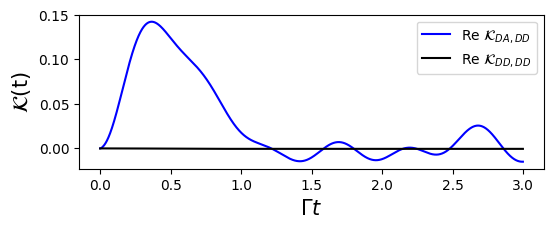

In [15]:
#plot the kernel without the last two boundary points that have numerical errors
plt.figure(figsize=(6,2))
plt.plot(timeVec[:-2], kernel[:-2,1,0].real,'b-', label='Re $\mathcal{K}_{DA,DD}$')
plt.plot(timeVec[:-2], kernel[:-2,0,0].real,'k-', label='Re $\mathcal{K}_{DD,DD}$')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\mathcal{K}$(t)',fontsize=15)
plt.legend(loc = 'upper right')

##Propagate the GQME

In [16]:
def PropagateRK4(currentTime, memTime, kernel,
                 sigma_hold, sigma):

    f_0 = Calculatef(currentTime, memTime,
                     kernel, sigma, sigma_hold)

    k_1 = sigma_hold + DT * f_0 / 2.
    f_1 = Calculatef(currentTime + DT / 2., memTime,
                     kernel, sigma, k_1)

    k_2 = sigma_hold + DT * f_1 /2.
    f_2 = Calculatef(currentTime + DT / 2., memTime,
                     kernel, sigma, k_2)

    k_3 = sigma_hold + DT * f_2
    f_3 = Calculatef(currentTime + DT, memTime,
                     kernel, sigma, k_3)

    sigma_hold += DT / 6. * (f_0 + 2. * f_1 + 2. * f_2 + f_3)

    return sigma_hold


In [17]:
def Calculatef(currentTime, memTime, kernel, sigma_array, kVec):
    global LN0, HBAR

    memTimeSteps = int(memTime / DT)
    currentTimeStep = int(currentTime / DT)

    f_t = np.zeros(kVec.shape, dtype=np.complex_)

    f_t -= 1.j / HBAR * LN0 @ kVec

    limit = memTimeSteps
    if currentTimeStep < (memTimeSteps - 1):
        limit = currentTimeStep
    for l in range(limit):
        f_t -= DT * kernel[l,:,:] @ sigma_array[currentTimeStep - l]

    return f_t


In [18]:
#read the memory kernel
timeVec,kernel = wr.read_superoper_array("K_Output/K_")

# array for reduced density matrix elements
sigma = np.zeros((TIME_STEPS, DOF_E_SQ), dtype=np.complex_)
# array to hold copy of sigma
sigma_hold = np.zeros(DOF_E_SQ, dtype = np.complex_)

# sets the initial state at Donor State
sigma[0,0] = 1.
sigma_hold[0] = 1.

# loop to propagate sigma
print(">>> Starting GQME propagation, memory time =", MEM_TIME)
for l in range(TIME_STEPS - 1): # it propagates to the final time step
    if l%100==0: print(l)
    currentTime = l * DT

    sigma_hold = PropagateRK4(currentTime, MEM_TIME, kernel, sigma_hold, sigma)

    sigma[l + 1] = sigma_hold.copy()

# prints sigma to files
wr.output_operator_array(timeVec, sigma, "GQME_Output/Sigma_")

>>> Starting GQME propagation, memory time = 3.001659990105585
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


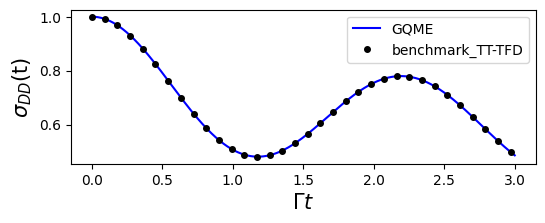

In [19]:
# Read the reference data and plot
timeVec, sigma_tt_tfd = wr.read_operator_array("TTTFD_Output/TFDSigma_")
timeVec, sigma = wr.read_operator_array("GQME_Output/Sigma_")

plt.figure(figsize=(6,2))
plt.plot(timeVec, sigma[:,0],'b-', label='GQME')
plt.plot(timeVec, sigma_tt_tfd[:,0] ,'ko', markersize=4, markevery=60, label='benchmark_TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend()

# Quantum Algorithms of GQME based on Dilation

## Solving the GQME to get the propagator

In [20]:
#read the memory kernel
timeVec,kernel = wr.read_superoper_array("K_Output/K_")

# array for Propagator superoperator elements
G_prop = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)

#time 0 propagator: identity superoperator
G_prop[0] = np.eye(DOF_E_SQ)
#array to hold copy of G propagator
G_prop_hold = np.eye((DOF_E_SQ), dtype=np.complex_)

# loop to propagate G_prop using GQME
print(">>> Starting GQME propagation, memory time =", MEM_TIME)
for l in range(TIME_STEPS - 1): # it propagates to the final time step
    if l%100==0: print(l)
    currentTime = l * DT

    G_prop_hold = PropagateRK4(currentTime, MEM_TIME, kernel, G_prop_hold, G_prop)

    G_prop[l + 1] = G_prop_hold.copy()

>>> Starting GQME propagation, memory time = 3.001659990105585
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


## Dilation of the non-unitary propagator

In [21]:
from numpy import linalg as la
import scipy.linalg as sp

def dilate(array):

  # Normalization factor of 1.5 to ensure contraction
  norm = la.norm(array,2)*1.5
  array_new = array/norm

  ident = np.eye(array.shape[0])

  # Calculate the conjugate transpose of the G propagator
  fcon = (array_new.conjugate()).T

  # Calculate the defect matrix for dilation
  fdef = sp.sqrtm(ident - np.dot(fcon, array_new))

  # Calculate the defect matrix for the conjugate of the G propagator
  fcondef = sp.sqrtm(ident - np.dot(array_new, fcon))

  # Dilate the G propagator to create a unitary operator
  array_dilated = np.block([[array_new, fcondef], [fdef, -fcon]])

  return array_dilated, norm

## Quantum Simulation of GQME with QASM Simulator

In [22]:
!pip install qiskit==1.2.0
!pip install qiskit_aer==0.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 28.7 MB/s eta 0:00:00


In [23]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator

In [24]:
# Create a dictionary to store the measurement results
result = {'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}

# Create lists to store the population for the acceptor and donor states
pop_accept = []
pop_donor = []

# initial state in the dilated space
rho0_dilated = np.concatenate((np.array([1 + 0j, 0, 0, 0]),np.zeros(DOF_E_SQ)))

for i in range(TIME_STEPS):

    qr = QuantumRegister(3)  # Create a quantum register with 3 qubits
    cr = ClassicalRegister(3)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_dilated, qr)

    # Dilated propagator
    U_G, norm = dilate(G_prop[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)

    # Apply the unitary operator to the quantum circuit's qubits
    qc.unitary(U_G_op, qr)
    # Measure the qubits and store the results in the classical register
    qc.measure(qr, cr)

    #Run the Simulation and Plot the Results
    simulator = QasmSimulator()
    shots = 2000  # Number of shots
    job = simulator.run(qc,shots=shots)
    counts = job.result().get_counts(qc)

    # Update the result dictionary
    for x in counts:
        result[x] = counts[x]

    # Calculate the populations of donor and acceptor states from measurement probabilities
    pd = np.sqrt(result['000'] / shots) * norm  # Multiply by the normalization factor
    pa = np.sqrt(result['011'] / shots) * norm  # Multiply by the normalization factor

    pop_donor.append(pd)  # Stacking the population for the donor state
    pop_accept.append(pa)  # Stacking the population for the acceptor state

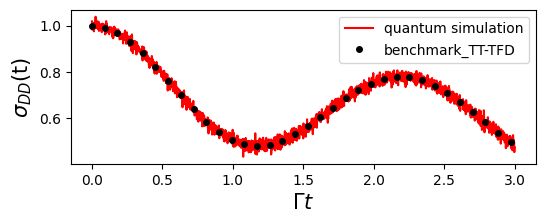

In [25]:
# Read the exact TT-TFD results
timeVec, sigma_tt_tfd = wr.read_operator_array("TTTFD_Output/TFDSigma_")
# Plot the population of the donor and acceptor states
plt.figure(figsize=(6,2))
plt.plot(timeVec, pop_donor, 'r-', label="quantum simulation")
plt.plot(timeVec, sigma_tt_tfd[:,0].real ,'ko', markersize=4, markevery=60, label='benchmark_TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = 'upper right')